In [1]:
import os, io, zipfile, tarfile, urllib.request, random, math, time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True
# -------------------------------
# Settings requested by the prompt
# -------------------------------
MAX_WORDS = 10_000    # consider only top 10k words
MAX_LEN   = 150       # cut/pad reviews at 150 tokens
TRAIN_100 = 100       # first experiment: 100 train
VAL_10K   = 10_000    # and 10k validate
EPOCHS    = 6
BATCH     = 32

# sizes for the sweep (to answer: when does learned > pretrained?)
TRAIN_SIZES = [100, 250, 500, 1000, 2000, 5000, 10_000]



TensorFlow: 2.19.0


In [2]:

# Step 1) Download IMDB raw text

def download_imdb_raw():
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    tgz_path, _ = urllib.request.urlretrieve(url)
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=".")
    # Remove unlabeled data
    unsup = os.path.join("aclImdb", "train", "unsup")
    if os.path.exists(unsup):
        import shutil
        shutil.rmtree(unsup, ignore_errors=True)

def read_imdb_split(split_dir):
    texts, labels = [], []
    for label in ["neg", "pos"]:
        folder = os.path.join(split_dir, label)
        for fname in sorted(os.listdir(folder)):
            if fname.endswith(".txt"):
                with open(os.path.join(folder, fname), encoding="utf-8") as f:
                    texts.append(f.read())
                labels.append(0 if label == "neg" else 1)
    return texts, np.array(labels, dtype="int32")

if not os.path.exists("aclImdb"):
    print("Downloading IMDB raw text...")
    download_imdb_raw()

train_texts, train_labels = read_imdb_split(os.path.join("aclImdb", "train"))
test_texts,  test_labels  = read_imdb_split(os.path.join("aclImdb", "test"))
print("Train docs:", len(train_texts), " Test docs:", len(test_texts))


/tmp/ipython-input-1839810004.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=".")


Train docs: 25000  Test docs: 25000


In [3]:

# Step 2) Tokenize (top 10k) + pad to 150

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words=MAX_WORDS, oov_token=None)
tok.fit_on_texts(train_texts)

def texts_to_padded(texts):
    seqs = tok.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, truncating="post", padding="post")

X_train_all = texts_to_padded(train_texts)
Y_train_all = train_labels.copy()

# shuffle training set (so early slices are not ordered by class)
idx = np.arange(len(X_train_all))
np.random.shuffle(idx)
X_train_all = X_train_all[idx]
Y_train_all = Y_train_all[idx]

# Optional held-out test set from official split (not required by the prompt)
X_test = texts_to_padded(test_texts)
Y_test = test_labels.copy()

print("X_train_all:", X_train_all.shape, " X_test:", X_test.shape)


X_train_all: (25000, 150)  X_test: (25000, 150)


In [4]:

# Step 3) Build GloVe embedding matrix (100d)

GLOVE_TXT = os.path.join("glove", "glove.6B.100d.txt")
if not os.path.exists(GLOVE_TXT):
    print("Downloading GloVe 6B (100d)...")
    os.makedirs("glove", exist_ok=True)
    glove_zip_url = "https://nlp.stanford.edu/data/glove.6B.zip"
    zip_path, _ = urllib.request.urlretrieve(glove_zip_url)
    with zipfile.ZipFile(zip_path) as z:
        z.extract("glove.6B.100d.txt", path="glove")

emb_index = {}
with open(GLOVE_TXT, encoding="utf-8") as f:
    for line in f:
        vals = line.split()
        word = vals[0]
        vec  = np.asarray(vals[1:], dtype="float32")
        emb_index[word] = vec

EMBED_DIM = 100
embedding_matrix = np.zeros((MAX_WORDS, EMBED_DIM), dtype="float32")
for word, i in tok.word_index.items():
    if i >= MAX_WORDS:
        continue
    vec = emb_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec
print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (10000, 100)


In [7]:

# Step 4) Model builders (BiLSTM)

def build_bilstm_learned(embed_dim=100, units=64, drop=0.2):
    inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")
    x = layers.Embedding(MAX_WORDS, embed_dim, input_length=MAX_LEN, name="learned_embed")(inputs)
    x = layers.Bidirectional(layers.LSTM(units, dropout=drop))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="BiLSTM_Learned")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_bilstm_glove(trainable=False, units=64, drop=0.2):
    inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")
    x = layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable=trainable,
        name="glove_embed"
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(units, dropout=drop))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="BiLSTM_GloVe")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Training: BiLSTM + Learned Embedding ---
Epoch 1/6
4/4 - 19s - 5s/step - accuracy: 0.5400 - loss: 0.6929 - val_accuracy: 0.4929 - val_loss: 0.6933
Epoch 2/6
4/4 - 27s - 7s/step - accuracy: 0.6700 - loss: 0.6876 - val_accuracy: 0.4975 - val_loss: 0.6939
Epoch 3/6
4/4 - 14s - 3s/step - accuracy: 0.6100 - loss: 0.6817 - val_accuracy: 0.4974 - val_loss: 0.6948
Epoch 4/6
4/4 - 21s - 5s/step - accuracy: 0.6400 - loss: 0.6711 - val_accuracy: 0.4980 - val_loss: 0.6970
Epoch 5/6
4/4 - 21s - 5s/step - accuracy: 0.7000 - loss: 0.6620 - val_accuracy: 0.4986 - val_loss: 0.7013
Epoch 6/6
4/4 - 14s - 3s/step - accuracy: 0.7400 - loss: 0.6355 - val_accuracy: 0.4997 - val_loss: 0.7115

--- Training: BiLSTM + GloVe (frozen) ---
Epoch 1/6
4/4 - 18s - 4s/step - accuracy: 0.5400 - loss: 0.6893 - val_accuracy: 0.5135 - val_loss: 0.6944
Epoch 2/6
4/4 - 21s - 5s/step - accuracy: 0.6500 - loss: 0.6701 - val_accuracy: 0.4956 - val_loss: 0.7090
Epoch 3/6
4/4 - 21s - 5s/step - accuracy: 0.5600 - loss: 0.6779

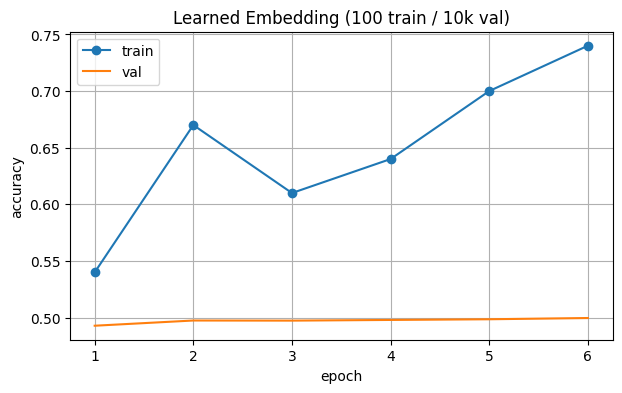

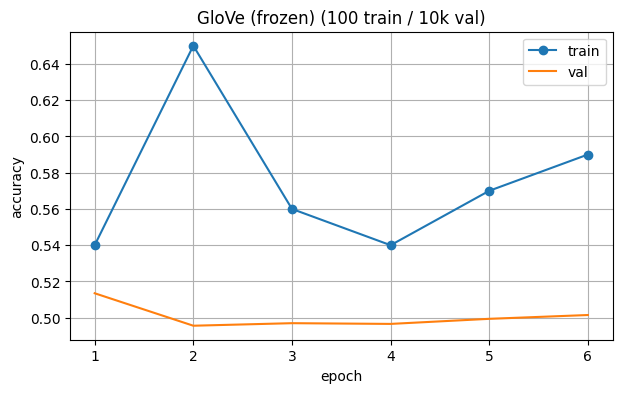

In [8]:

# Step 5) First experiment (100 train / 10k val)

x_train_100 = X_train_all[:TRAIN_100]
y_train_100 = Y_train_all[:TRAIN_100]
x_val_10k   = X_train_all[TRAIN_100:TRAIN_100+VAL_10K]
y_val_10k   = Y_train_all[TRAIN_100:TRAIN_100+VAL_10K]

def train_model(m, xtr, ytr, xv, yv, label):
    print(f"\n--- Training: {label} ---")
    h = m.fit(xtr, ytr, validation_data=(xv, yv),
              epochs=EPOCHS, batch_size=BATCH, verbose=2)
    return h

model_learned = build_bilstm_learned()
hist_learned  = train_model(model_learned, x_train_100, y_train_100, x_val_10k, y_val_10k,
                            "BiLSTM + Learned Embedding")

model_glove = build_bilstm_glove(trainable=False)
hist_glove  = train_model(model_glove, x_train_100, y_train_100, x_val_10k, y_val_10k,
                          "BiLSTM + GloVe (frozen)")

# Optional: tiny fine-tune for GloVe (2 epochs, low LR)
model_glove.get_layer("glove_embed").trainable = True
model_glove.compile(optimizer=keras.optimizers.Adam(1e-4),
                    loss="binary_crossentropy", metrics=["accuracy"])
print("\n--- Fine-tuning GloVe embed for 2 epochs ---")
hist_glove_ft = model_glove.fit(x_train_100, y_train_100,
                                validation_data=(x_val_10k, y_val_10k),
                                epochs=2, batch_size=BATCH, verbose=2)

# quick curves
def plot_history(h, title):
    acc = h.history.get("accuracy", [])
    val = h.history.get("val_accuracy", [])
    plt.figure()
    plt.plot(range(1, len(acc)+1), acc, "o-", label="train")
    plt.plot(range(1, len(val)+1), val, "-", label="val")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

plot_history(hist_learned, "Learned Embedding (100 train / 10k val)")
plot_history(hist_glove, "GloVe (frozen) (100 train / 10k val)")


n=  100 | learned=0.497 | glove=0.534
n=  250 | learned=0.506 | glove=0.524
n=  500 | learned=0.538 | glove=0.551
n= 1000 | learned=0.586 | glove=0.575
n= 2000 | learned=0.751 | glove=0.635
n= 5000 | learned=0.810 | glove=0.650
n=10000 | learned=0.831 | glove=0.785


,train_samples,val_acc_learned,val_acc_glove
0,100,0.4969,0.5344
1,250,0.5057,0.5235
2,500,0.5375,0.5506
3,1000,0.5861,0.5750
4,2000,0.7511,0.6349
5,5000,0.8097,0.6504
6,10000,0.8307,0.7846


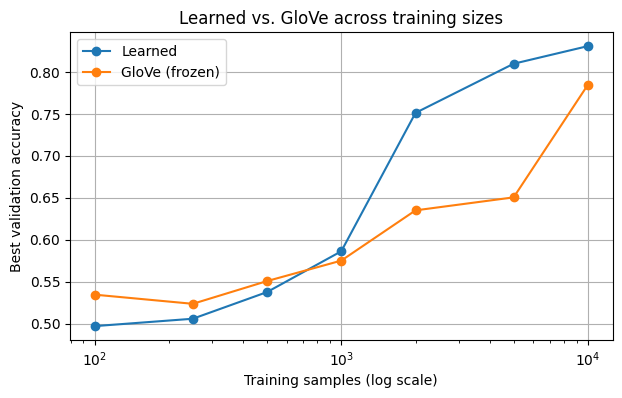

{'test_acc_learned': 0.5044800043106079, 'test_acc_glove_ft': 0.5094799995422363}


In [9]:

# Step 6) Training-size sweep

def best_val_acc(history):
    return float(max(history.history.get("val_accuracy", [0.0])))

records = []
for n in TRAIN_SIZES:
    xtr = X_train_all[:n]
    ytr = Y_train_all[:n]
    xv  = X_train_all[n:n+VAL_10K]
    yv  = Y_train_all[n:n+VAL_10K]
    if len(xv) < 1:
        break

    # small heuristic to reduce epochs for tiny n
    ep = max(2, min(6, int(6 * 100 / max(100, n))))

    mA = build_bilstm_learned()
    hA = mA.fit(xtr, ytr, validation_data=(xv, yv),
                epochs=ep, batch_size=BATCH, verbose=0)
    aA = best_val_acc(hA)

    mB = build_bilstm_glove(trainable=False)
    hB = mB.fit(xtr, ytr, validation_data=(xv, yv),
                epochs=ep, batch_size=BATCH, verbose=0)
    aB = best_val_acc(hB)

    records.append((n, aA, aB))
    print(f"n={n:5d} | learned={aA:.3f} | glove={aB:.3f}")

# show results
import pandas as pd
df = pd.DataFrame(records, columns=["train_samples", "val_acc_learned", "val_acc_glove"])
display(df)

plt.figure()
plt.plot(df["train_samples"], df["val_acc_learned"], "o-", label="Learned")
plt.plot(df["train_samples"], df["val_acc_glove"], "o-", label="GloVe (frozen)")
plt.xscale("log")
plt.xlabel("Training samples (log scale)")
plt.ylabel("Best validation accuracy")
plt.title("Learned vs. GloVe across training sizes")
plt.legend()
plt.show()

# Optional: Evaluate on the official test split (not required)
test_learned = model_learned.evaluate(X_test, Y_test, verbose=0)[1]
test_glove   = model_glove.evaluate(X_test, Y_test, verbose=0)[1]
print({"test_acc_learned": float(test_learned),
       "test_acc_glove_ft": float(test_glove)})


In [11]:

# Step 7) Short textual summary (fill after running)

def quick_takeaway():
    a0 = best_val_acc(hist_learned)
    b0 = best_val_acc(hist_glove)
    line1 = f"Initial 100/10k: Learned val_acc={a0:.3f} | GloVe(frozen) val_acc={b0:.3f}"

    cross = None
    for n, aA, aB in records:
        if aA >= aB:
            cross = n
            break
    if cross is None:
        line2 = "Learned did not overtake GloVe within tested sizes."
    else:
        line2 = f"Learned first overtook GloVe around ~{cross} training samples."

    return line1 + "\n" + line2 + "\n" + \
           "Reasoning: Pretrained vectors can help with tiny data but may be domain-mismatched; " \
           "as data grows, task-specific learned embeddings catch up and surpass."

print("\n" + quick_takeaway())


Initial 100/10k: Learned val_acc=0.500 | GloVe(frozen) val_acc=0.513
Learned first overtook GloVe around ~1000 training samples.
Reasoning: Pretrained vectors can help with tiny data but may be domain-mismatched; as data grows, task-specific learned embeddings catch up and surpass.
